In [1167]:
#all_volumes["BRK.B"].tail()
all_quotes.head()

,CSCO,OREX,HUBS,SPXU,UAL,TROW,ISRG,NVR,TLRY,PRGO,...,DLM,LOUD,SBSA,ELGX,BPUR,GIC,HGSI,ENER,HBOC,WWY
1996-01-02,3.201162,NaN,NaN,NaN,NaN,3.552658,NaN,9.952607,NaN,10.551303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,3.075429,NaN,NaN,NaN,NaN,3.575512,NaN,9.952607,NaN,10.664477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,2.959754,NaN,NaN,NaN,NaN,3.552474,NaN,10.077014,NaN,10.555656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,2.996636,NaN,NaN,NaN,NaN,3.575512,NaN,9.952607,NaN,10.664477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,2.967717,NaN,NaN,NaN,NaN,3.501790,NaN,9.952607,NaN,11.099762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1168]:
all_quotes.to_csv("Quote_Tables/all_quotes.csv")
all_volumes.to_csv("Quote_Tables/all_volumes.csv")

# Strategy Implementation

In [1]:
# Import nesessary libraries and read data in pandas dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from itertools import product
# Quotes should have first column of dates followed by
# columns of closing prices named after the stocks.
# The same applies for table of volumes
all_quotes = pd.read_csv("../Quote_Tables/all_quotes.csv", index_col=0, parse_dates=True)
all_volumes = pd.read_csv("../Quote_Tables/all_volumes.csv", index_col=0, parse_dates=True)

#Getting risk-free rates
risk_free = pd.read_csv("F-F_Research_Data_Factors.csv" )
mean_rf_rate = risk_free.loc[risk_free["Year"]>=1999].iloc[:,4].mean()/100
print(mean_rf_rate)

0.01792380952380953


In [3]:
risk_free.loc[(risk_free["Year"]>=1927) & (risk_free["Year"]<=2011) ].iloc[:,4].mean()

3.6272941176470592

In [12]:
#all_quotes = all_quotes.loc[:'2009']
#all_volumes = all_volumes.loc[:'2009']

In [2]:
def calculate_max_drawdown(array, compound=False):
    array = np.array(array)
    # Getting increasing local maxima's indices sequence
    indices_of_maxs = []
    maximum = array[0]
    if array[0] > array[1]: indices_of_maxs.append(0)
    for x in range(1, len(array)-1):
        if array[x] > array[x-1] and array[x] > array[x+1] \
        and array[x]>maximum:
            maximum = array[x]
            indices_of_maxs.append(x)
    if array[-1] > maximum: indices_of_maxs.append(len(array)-1)
    
    # Calculating drawdowns in inter local maxima regions and
    # selecting max of them
    maxs = array[indices_of_maxs]
    regions = np.split(array, indices_of_maxs)
    regions.pop(0)
    mins = [min(region) for region in regions]

    if not compound: return max(maxs - mins)
    else: return max(1- mins/maxs)

simple mean: 0.07782232025027057	std_dev: 0.16643930646008517	sharp ratio: 0.3598820014359148
simple drawdown: 0.6868660474865808	calmar ratio: 0.08720551983264432
CAGR: 0.06561328999664684	compound drawdown: 0.5290725563820062	recovery_ratio: 11.849652361450582
alpha: 0.0	beta: 1.0


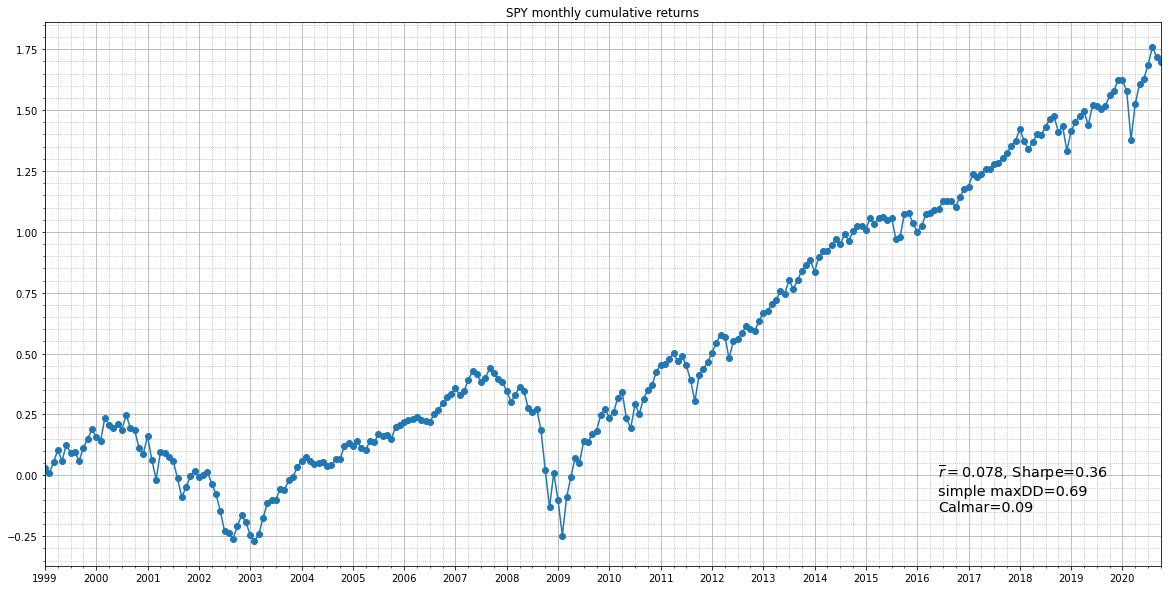

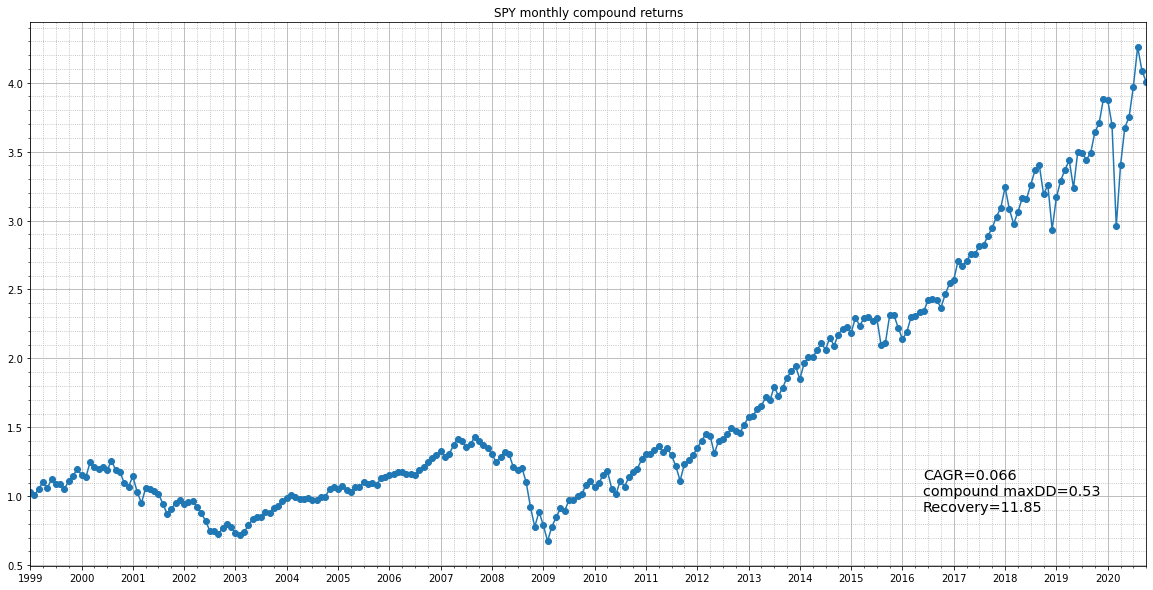

In [3]:
from scipy.stats import linregress
# Performance indicators calculation
class StrategyEvaluation:
    """Representation of generic strategy used to calculate perfomance metrics"""
    
    # Reference SPY returns for alpha and beta calculation of a strategy
    spy_returns = all_quotes['SPY'][all_quotes.index >= pd.to_datetime('1999-01')]. \
    resample('M', kind='period').first() \
    .pct_change().shift(-1).dropna()
    
    def __init__(self, strategy_returns):
        """ Using a strategy's monthly returns, calcutates and stores various time-series
        of the strategy and the its performance metrics such as sharp and calmar ratios """
        
        self.returns = strategy_returns
        self.cum_returns = self.returns.cumsum()
        self.compound_rets = (1+self.returns).cumprod()
        # if compound return goes zero or below, it means the capital is ruined
        if np.any(self.compound_rets <= 0):
            time_of_fail = (self.compound_rets <= 0).idxmax()
            #time_of_fail = self.compound_rets.index.get_loc(time_of_fail)
            self.compound_rets[time_of_fail+1:] = self.compound_rets[time_of_fail]           
        
        self.mean_monthly_return = self.returns.mean()
        
        # Simple annual performance metrics
        self.expected_return = self.mean_monthly_return * 12
        self.std_dev = np.std(self.returns) * np.sqrt(12)
        self.sharp_ratio = (self.expected_return-mean_rf_rate)/self.std_dev
        
        self.simple_drawdown = calculate_max_drawdown(self.cum_returns)
        self.calmar_ratio = (self.expected_return - mean_rf_rate) \
        / self.simple_drawdown
        
        # Compound annual performance metrics
        self.cagr = self.compound_rets[-1] ** (1/len(self.compound_rets)*12) - 1        
        self.comp_drawdown = calculate_max_drawdown(self.compound_rets, True)
        self.recovery_ratio = -np.log(1-self.comp_drawdown)/np.log(1+self.cagr)
        
        # Alpha and beta in comparison with SPY
        aligned_strats = pd.concat([self.returns, spy_returns], axis=1).dropna()
        #print(aligned_strats)
        self.regr_res = linregress(x=aligned_strats.iloc[:, 0], y=aligned_strats.iloc[:, 1])
        self.alpha, self.beta = self.regr_res.intercept*12, self.regr_res.slope
        
    def __str__(self):
        return f"simple mean: {self.expected_return}\tstd_dev: {self.std_dev}\t" +\
        f"sharp ratio: {self.sharp_ratio}\n" +\
        f"simple drawdown: {self.simple_drawdown}\tcalmar ratio: {self.calmar_ratio}\n" +\
        f"CAGR: {self.cagr}\tcompound drawdown: {self.comp_drawdown}\t" +\
        f"recovery_ratio: {self.recovery_ratio}\n" +\
        f"alpha: {self.alpha}\tbeta: {self.beta}"
    
    def graph_returns(self, ret_type=None, returns_arr=None, title='', annot_text=''):
        """ret_types are: simple, cumulative, compound"""
        
        simple_metrics = r"$\overline{r}=$"+f"{self.expected_return:.3f}, " + \
                f"Sharpe={self.sharp_ratio:.2f}\n"+\
                f"simple maxDD={self.simple_drawdown:.2f}\n"+\
                f"Calmar={self.calmar_ratio:.2f}"
        compound_metrics = f"CAGR={self.cagr:.3f}\ncompound maxDD={self.comp_drawdown:.2f}\n" +\
                f"Recovery={self.recovery_ratio:.2f}"
        types_of_returns={
            "simple":(self.returns, ' monthly returns', simple_metrics),
            "cumulative":(self.cum_returns, ' monthly cumulative returns', simple_metrics),
            "compound":(self.compound_rets, ' monthly compound returns', compound_metrics),
        }
        if ret_type != None:
            returns_arr, title, annot_text = types_of_returns[ret_type]
        elif returns_arr == None: returns_arr = self.cum_returns
            
        ax = returns_arr.plot(figsize=(20,10), grid=True, style='o-',
                          title=f"{self.returns.name}" + title)
        ax.minorticks_on()
        plt.grid(which='minor', linestyle = ':')
        plt.xticks(returns_arr.index.values[::12])
        ax.set_xticklabels(returns_arr.index.year[::12])
        plt.text(x=0.8, y=0.1, s=annot_text, transform=ax.transAxes,size='x-large')
        plt.show()



spy_returns = all_quotes['SPY'][all_quotes.index >= pd.to_datetime('1999-01')]. \
resample('M', kind='period').first() \
.pct_change().shift(-1).dropna()
benchmark= StrategyEvaluation(spy_returns)
print(str(benchmark))
benchmark.graph_returns('cumulative')
benchmark.graph_returns('compound')

In [5]:
class LS_Strategy:
    """Representation of long-short strategy"""
    def __init__(self,lookback_period, holding_period, leg_length):
        """Initializer. Leg length is n of stocks for both short and 
        long legs of the portfolio. Total number of stocks is leg_length*2"""
        self.lookback_period = lookback_period
        self.holding_period = holding_period
        self.leg_length = leg_length
        """monthly returns for each of holding_period substrategies which
        start trading from the beggining 0 to holding_period - 1 month since
        first date passed to add_results"""
        substrategies_names = np.arange(holding_period)
        self.raw_returns = pd.DataFrame(columns = substrategies_names, 
                                        index=pd.to_datetime([]))

        """ Holdings store triples of date, lists of names for long and short 
        stocks in the portfolio"""
        self.holdings = []
    
    def add_results(self, dates, rets, long_stocks, short_stocks):
        # Deciding which substrategy (offset) add returns to given that they can overlap
        if not self.raw_returns.empty:
            offset = (pd.Period(dates[0], freq='M') - self.first_date).n % self.holding_period
        else: 
            self.first_date = pd.Period(dates[0], freq='M')
            offset = 0
        
        self.raw_returns = self.raw_returns.reindex(
            self.raw_returns.index.union(dates))
        self.raw_returns.loc[dates, offset] = rets
        
        self.holdings.append((dates[0], long_stocks, short_stocks))
        
    def calculate_performance(self):
        """ Calcutates all perfomance metrics and cumulative time-series for
        simple and compound returns, storing almost all results in stats variable"""
        
        self.mean_overlap_return = np.mean(self.raw_returns)
        
        self.adj_returns = self.raw_returns.mean(axis=1, skipna=True). \
        rename(f"LS strat lb_p {self.lookback_period}, h_p {self.holding_period}, n_s {self.leg_length}")
        self.adj_returns.index = self.adj_returns.index.to_period('M')
        
        self.stats = StrategyEvaluation(self.adj_returns)
        
    def show_perf_results(self):
        print(f"Lookback period: {self.lookback_period}\t" + \
              f"Hold period: {self.holding_period}\t" + \
              f"Leg length: {self.leg_length}")
        print(str(self.stats))

In [6]:
from scipy.optimize import minimize, LinearConstraint, Bounds
def get_optimal_weights(returns):
    def portfolio_rets_variance(weights, returns):
        return np.var(returns @ weights.T)
    n = int(returns.shape[1] / 2) #number of stocks in one leg of portfolio
    neg_weights_constraint = [1]*n + [0]*n
    pos_weights_constraint = [0]*n + [1]*n
    all_constraints = np.array([neg_weights_constraint, pos_weights_constraint])
    constraint = LinearConstraint(all_constraints, lb=[-1, 1], ub=[-1, 1])

    lower_bounds = [-np.inf]*n + [0]*n
    upper_bounds = [0]*n + [np.inf]*n
    bound = Bounds(lower_bounds, upper_bounds)
    x_init = np.array([-1/n]*n + [1/n]*n)
    '''print("New Result:")
    print(np.var(returns @ x_init.T))
    print(returns @ x_init.T)'''

    res = minimize(portfolio_rets_variance, x0=x_init, args=(returns,),
                   bounds = bound, constraints=constraint)
    '''print(np.var(returns @ res.x.T))
    print(returns @ res.x.T)
    print(np.round(res.x, 3))'''
    return np.round(res.x, 3)

In [7]:
# Strategy hyperparameters. Periods are in months
lookback_periods = [1, 3, 6, 9, 12, 18, 24, 36]
holding_periods = [1, 3, 6, 9, 12]
n_best_stocks = [10, 20, 40, 80]


# Creating strategies with all combinations of hyperparameters
strats_store = np.empty(shape=[len(lookback_periods), 
       len(holding_periods), len(n_best_stocks)], dtype=object)
for i, j, k in product(range(len(lookback_periods)), 
       range(len(holding_periods)), range(len(n_best_stocks))):
    strats_store[i, j, k] = LS_Strategy(
    lookback_periods[i], holding_periods[j], n_best_stocks[k])


In [8]:
def run_strategies(start_date, rebalance = False, opt_weights = False):
    # Finding nearest date not less than start_date and its index
    current_index = all_quotes.index.get_loc(start_date, method="backfill")
    nearest_date = all_quotes.index[current_index]

    # Getting tickers for all stocks which had average daily volume > $50 m
    # for a month prior to start_day
    ruleout_date = start_date - relativedelta(months=1)

    ruleout_indices_mask = \
        (all_quotes.index >= ruleout_date) & (all_quotes.index <= nearest_date)
    ruleout_quotes = all_quotes.loc[ruleout_indices_mask]
    ruleout_volumes = all_volumes.loc[ruleout_indices_mask]
    dollar_volumes = ruleout_quotes * ruleout_volumes
    mean_dvolumes = dollar_volumes.agg(np.mean)

    tickers = mean_dvolumes[mean_dvolumes>50000000].index.values
    
    # Selecting stocks with sufficient history for weights optimization
    if (opt_weights):
        optimization_start_date = nearest_date - relativedelta(months=12)
        optimization_start = all_quotes.index.get_loc(optimization_start_date, method="backfill")
        tickers = all_quotes.iloc[optimization_start][tickers].dropna().index.values
    init_hold_period = holding_periods[0]
    
    # Iterate over all hyperparameters' space
    for lb_period, n_stocks, hold_period in product(lookback_periods, 
        n_best_stocks, holding_periods):
        # Getting dates for calculation of prior and future returns
        lb_approx_date = nearest_date - relativedelta(months=lb_period)
        lb_start = all_quotes.index.get_loc(lb_approx_date, method="backfill")
        temp_hp = hold_period
        while temp_hp >0:
            hold_approx_date = start_date + relativedelta(months=temp_hp)
            if hold_approx_date > all_quotes.index[-1]:
                #print(start_date, "not enough dates to calc", lb_period, hold_period, n_stocks)
                temp_hp-=1
                continue
            break
        hold_end = all_quotes.index.get_loc(hold_approx_date, method="backfill")

        # Finding out prior returns
        prior_returns = all_quotes.iloc[current_index][tickers]/ \
            all_quotes.iloc[lb_start][tickers] -1
        # Dropping stocks without sufficient history
        # and sorting them by returns
        pr_rets_sorted = prior_returns.dropna().sort_values()
        curr_tickers = pr_rets_sorted.index.values

        # Selecting best and worst performing stocks
        best_stocks = curr_tickers[-n_stocks:]
        worst_stocks = curr_tickers[:n_stocks]
        selected_all = np.concatenate([worst_stocks,best_stocks])

        # Getting weights
        if opt_weights and hold_period == init_hold_period:
            prev_returns = all_quotes[optimization_start:current_index+1][selected_all]. \
                resample('M', closed='right', kind='period').first().\
                pct_change().dropna()
            weights = get_optimal_weights(prev_returns)
        elif not opt_weights:
            leg_len = len(worst_stocks)
            weights = np.array(
            [-1/leg_len]*leg_len + [1/leg_len]*leg_len)
        
        # Filling nan values in case some stocks got delisted
        # and selecting only monthly observations between start_date and hold_end
        current_table = all_quotes[current_index:hold_end+1][selected_all] \
            .fillna(method='ffill', axis=0)
        monthly_approx_dates = [start_date + relativedelta(months=x) \
            for x in range(0, temp_hp+1)]
        monthly_indices = [current_table.index.get_loc(x, method="backfill") \
            for x in monthly_approx_dates]
        # Calculating growth ratios for individual stocks, m/m and cumulative
        # A shift by one period backwards is used to bind a return to a start 
        # of a month, in which the decision is taken, not of a next one
        returns = current_table.iloc[monthly_indices].pct_change().shift(-1) \
            .dropna() + 1
        cum_returns = returns.cumprod()

        # Amount of capital borrowed for shorting is equal to pre-owned
        # capital used for long positions, adding +1 to overall position
        cum_strategy_returns = cum_returns.dot(weights) + 1 
                
        # Checking if a strategy went bust at any of the steps
        # At all subsequent steps strategy's equity and returns are zero
        negative_equity = cum_strategy_returns <= 0
        if np.any(negative_equity):
            time_of_fail = negative_equity.idxmax()
            time_of_fail = cum_strategy_returns.index.get_loc(time_of_fail)
            cum_strategy_returns[time_of_fail+1:] = cum_strategy_returns[time_of_fail]

        # Calculating monthly strategy returns
        strategy_returns = cum_strategy_returns - cum_strategy_returns.shift(periods=1, 
                                                                     fill_value=1) 
        """if np.any(strategy_returns >=10):
            print(start_date, strategy_returns, lb_period, hold_period, n_stocks)
            print(cum_returns)
            print(cum_strategy_returns)
"""
        if rebalance: 
            returns = returns -1
            strategy_returns =  returns.dot(weights)

        # Storing results for given start_date and set of hyperparameters
        #print(start_date, lb_period, hold_period, n_stocks, strategy_returns.mean())
        #print(returns)
        #print(current_table.iloc[monthly_indices])
        strats_store[lookback_periods.index(lb_period), 
                     holding_periods.index(hold_period),
                     n_best_stocks.index(n_stocks)
                    ].add_results(strategy_returns.index.values, strategy_returns, best_stocks, worst_stocks)
    print("End of calculations for month:", start_date)


In [9]:
# Dates to begin and to end backtest runs
beginning_date = datetime.strptime("1999-01-01", '%Y-%m-%d')
#beginning_date = datetime.strptime("2010-01-01", '%Y-%m-%d')
last_date_to_consider = all_quotes.index[-1] - relativedelta(months=1)

while beginning_date < last_date_to_consider:
    run_strategies(beginning_date, rebalance=False, opt_weights = False)
    beginning_date = beginning_date + relativedelta(months=1)
    
for x in strats_store.flat: x.calculate_performance()

End of calculations for month: 1999-01-01 00:00:00
End of calculations for month: 1999-02-01 00:00:00
End of calculations for month: 1999-03-01 00:00:00
End of calculations for month: 1999-04-01 00:00:00
End of calculations for month: 1999-05-01 00:00:00
End of calculations for month: 1999-06-01 00:00:00
End of calculations for month: 1999-07-01 00:00:00
End of calculations for month: 1999-08-01 00:00:00
End of calculations for month: 1999-09-01 00:00:00
End of calculations for month: 1999-10-01 00:00:00
End of calculations for month: 1999-11-01 00:00:00
End of calculations for month: 1999-12-01 00:00:00
End of calculations for month: 2000-01-01 00:00:00
End of calculations for month: 2000-02-01 00:00:00
End of calculations for month: 2000-03-01 00:00:00
End of calculations for month: 2000-04-01 00:00:00
End of calculations for month: 2000-05-01 00:00:00
End of calculations for month: 2000-06-01 00:00:00
End of calculations for month: 2000-07-01 00:00:00
End of calculations for month: 

End of calculations for month: 2012-06-01 00:00:00
End of calculations for month: 2012-07-01 00:00:00
End of calculations for month: 2012-08-01 00:00:00
End of calculations for month: 2012-09-01 00:00:00
End of calculations for month: 2012-10-01 00:00:00
End of calculations for month: 2012-11-01 00:00:00
End of calculations for month: 2012-12-01 00:00:00
End of calculations for month: 2013-01-01 00:00:00
End of calculations for month: 2013-02-01 00:00:00
End of calculations for month: 2013-03-01 00:00:00
End of calculations for month: 2013-04-01 00:00:00
End of calculations for month: 2013-05-01 00:00:00
End of calculations for month: 2013-06-01 00:00:00
End of calculations for month: 2013-07-01 00:00:00
End of calculations for month: 2013-08-01 00:00:00
End of calculations for month: 2013-09-01 00:00:00
End of calculations for month: 2013-10-01 00:00:00
End of calculations for month: 2013-11-01 00:00:00
End of calculations for month: 2013-12-01 00:00:00
End of calculations for month: 

<ipython-input-3-4229b5791bc0>:36: RuntimeWarning: invalid value encountered in double_scalars
  self.cagr = self.compound_rets[-1] ** (1/len(self.compound_rets)*12) - 1
<ipython-input-3-4229b5791bc0>:38: RuntimeWarning: invalid value encountered in log
  self.recovery_ratio = -np.log(1-self.comp_drawdown)/np.log(1+self.cagr)
<ipython-input-3-4229b5791bc0>:36: RuntimeWarning: invalid value encountered in double_scalars
  self.cagr = self.compound_rets[-1] ** (1/len(self.compound_rets)*12) - 1
<ipython-input-3-4229b5791bc0>:38: RuntimeWarning: invalid value encountered in log
  self.recovery_ratio = -np.log(1-self.comp_drawdown)/np.log(1+self.cagr)
<ipython-input-3-4229b5791bc0>:36: RuntimeWarning: invalid value encountered in double_scalars
  self.cagr = self.compound_rets[-1] ** (1/len(self.compound_rets)*12) - 1
<ipython-input-3-4229b5791bc0>:38: RuntimeWarning: invalid value encountered in log
  self.recovery_ratio = -np.log(1-self.comp_drawdown)/np.log(1+self.cagr)
<ipython-input-3

In [77]:
reb_nonoptimized_strats = strats_store.copy()

In [10]:
nonreb_nonoptimized_strats = strats_store.copy()

In [11]:
reb_optimized_strats = strats_store.copy()

In [43]:
nonreb_optimized_strats = strats_store.copy()

# Analysis of all strategies performance

In [12]:
from warnings import filterwarnings
filterwarnings('ignore')

curr_store = nonreb_nonoptimized_strats
#for x in curr_store.flat: x.calculate_performance()
    
# Getting output as pandas dataframe
metrics = ['E(r)', 'Sharpe', 'Calmar']
table = pd.DataFrame(index=lookback_periods,
                    columns=pd.MultiIndex.from_product([holding_periods, metrics], 
                                                      names = ['hold period', 'metrics']))
table.index.rename(r"lookback", inplace=True)
n_stocks_ind=2
for i, j, in product(range(len(lookback_periods)), 
       range(len(holding_periods))):
    strat = curr_store[i, j, n_stocks_ind]
    table.loc[strat.lookback_period, strat.holding_period]= \
    [strat.stats.expected_return, strat.stats.sharp_ratio, strat.stats.calmar_ratio]
    #f"{strat.stats.expected_return:.3f}, {strat.stats.sharp_ratio:.2f}, " \
    #+ f"{strat.stats.calmar_ratio:.2f}"
table_styled = table.style.format( "{:.2f}", subset=[False, True, True]*5).\
format( "{:.3f}", subset=[True, False, False]*5).\
background_gradient(subset=[True, False, False]*5).\
background_gradient(subset=[False, True, False]*5, cmap = "YlGn").\
background_gradient(subset=[False, False, True]*5, cmap = "PuRd")
#highlight_max( subset=[True, False, False]*5)
table_styled

In [102]:
# These models are trained on a subperiod of the sample.
training_perf = strats_store.copy()

In [233]:
# These models are trained on a subperiod of the sample.
training_perf_nr_opt = strats_store.copy()

In [117]:
# These models are trained on a subperiod of the sample.
test_perf = strats_store.copy()

In [235]:
tmp_perf_compare = []
for x1, x2 in zip(training_perf_nr_opt.flat, nonreb_optimized_strats.flat):
    tmp_perf_compare.append(
    [x1.lookback_period, x1.holding_period, x1.leg_length,
    x1.stats.calmar_ratio, x2.stats.calmar_ratio])
table_head = ['Lookback period', 'Holding period', 'Leg length', \
       '1999-2009 Calmar', 'All sample Calmar']
perf_compare = pd.DataFrame(tmp_perf_compare, columns=table_head).\
    sort_values('1999-2009 Calmar', ascending=False)
perf_compare['All sample rank'] = \
    perf_compare['All sample Calmar'].rank(ascending=False)
perf_compare.head(10)

,Lookback period,Holding period,Leg length,1999-2009 Calmar,All sample Calmar,All sample rank
7,1,3,80,0.462006,0.110686,71.0
16,1,12,10,0.385677,0.280992,2.0
24,3,3,10,0.349620,0.228182,6.0
17,1,12,20,0.333111,0.277741,3.0
13,1,9,20,0.328647,0.269299,4.0
21,3,1,20,0.319070,0.228087,8.0
32,3,9,10,0.312526,0.178782,23.0
4,1,3,10,0.302127,0.157012,32.0
36,3,12,10,0.284234,0.174629,25.0
63,9,1,80,0.282964,0.203719,11.0


In [236]:
perf_compare.to_excel('Nonreb opt cross-validation.xlsx', index=False)

In [227]:
with pd.ExcelWriter('colored_metrics nonreb_opt.xlsx', mode='a', engine="openpyxl") as writer:
    table_styled.to_excel(writer, sheet_name='80')

In [1464]:
table_html = table_styled.render()
with open('20.html', 'w') as f:
    f.write(table_html)

In [13]:
cols = ['Lookback period', 'Holding period', 'Leg length', \
       'mean', 'std', "Sharpe ratio", \
       'simple drawdown', 'Calmar ratio', \
       'CAGR', 'compound drawdown', 'Recovery ratio', \
       'alpha', 'beta', 'simple total', 'compound total']
tmp_strats_perf = []
for x in curr_store.flat:
    tmp_strats_perf.append(
        [x.lookback_period, x.holding_period, x.leg_length, \
        x.stats.expected_return, x.stats.std_dev, x.stats.sharp_ratio, \
        x.stats.simple_drawdown, x.stats.calmar_ratio, \
        x.stats.cagr, x.stats.comp_drawdown, x.stats.recovery_ratio, \
        x.stats.alpha, x.stats.beta, x.stats.cum_returns[-1], x.stats.compound_rets[-1]-1 ])
pd.options.display.max_rows=None
strats_perf = pd.DataFrame(tmp_strats_perf, columns=cols)
strats_perf
#pd.reset_option('display.max_rows')

,Lookback period,Holding period,Leg length,mean,std,Sharpe ratio,simple drawdown,Calmar ratio,CAGR,compound drawdown,Recovery ratio,alpha,beta,simple total,compound total
0,1,1,10,-0.275835,0.943782,-0.311257,8.084344,-0.036337,NaN,1.002418,NaN,0.068485,-0.033850,-6.022403,-1.004531
1,1,1,20,-0.103262,0.668723,-0.181220,3.808830,-0.031817,NaN,1.010153,NaN,0.070267,-0.073167,-2.254558,-1.019660
2,1,1,40,-0.047760,0.471538,-0.139298,2.428532,-0.027047,-0.164068,0.992938,-27.638505,0.071963,-0.122679,-1.042766,-0.980014
3,1,1,80,-0.020446,0.337237,-0.113778,1.505633,-0.025484,-0.077829,0.925368,-32.029491,0.073998,-0.187050,-0.446413,-0.829505
4,1,3,10,-0.094211,0.456448,-0.245668,3.223776,-0.034784,-0.201481,0.997217,-26.152203,0.071468,-0.067451,-2.056935,-0.992645
5,1,3,20,-0.012015,0.336768,-0.088899,1.543158,-0.019401,-0.071571,0.923807,-34.667980,0.076394,-0.118906,-0.262317,-0.802372
6,1,3,40,0.004083,0.259682,-0.053298,0.958761,-0.014436,-0.031045,0.804671,-51.782040,0.078669,-0.207444,0.089153,-0.497705
7,1,3,80,0.012023,0.191595,-0.030796,0.617144,-0.009561,-0.006983,0.583931,-125.134856,0.081646,-0.318019,0.262512,-0.141871
8,1,6,10,0.000098,0.333232,-0.053494,1.692132,-0.010535,-0.058944,0.917653,-41.098203,0.077827,-0.049495,0.002139,-0.734576
9,1,6,20,0.016072,0.250320,-0.007397,1.062660,-0.001742,-0.017479,0.731503,-74.567776,0.078131,-0.019177,0.350912,-0.319553


In [15]:
column = strats_perf['beta']
column.min(), column.max(), column.mean()

(-0.3180185570280653, 0.18565873549204362, -0.014051725625984437)

In [46]:
strats_perf.to_excel('nonrebalanced nonoptimized.xlsx')

In [16]:
# How many strategies are superior to benchmark in key metrics
bested_sharp = sum(strats_perf['Sharpe ratio'] >= benchmark.sharp_ratio)
bested_calmar = sum(strats_perf['Calmar ratio'] >= benchmark.calmar_ratio)
bested_recovery = sum((strats_perf['Recovery ratio'] <= benchmark.recovery_ratio) \
                      & (strats_perf['Recovery ratio']>0))
bested_mean = sum(strats_perf['mean'] >= benchmark.expected_return)
bested_cagr = sum(strats_perf['CAGR'] >= benchmark.cagr)
pos_mean = sum(strats_perf['mean'] >= 0)
pos_cagr = sum(strats_perf['CAGR'] >= 0)
print(bested_sharp, bested_calmar, bested_recovery)
print(bested_mean, bested_cagr)
print(pos_mean, pos_cagr)

11 36 8
74 19
147 90


In [17]:
print(strats_perf['mean'].mean())
print(strats_perf['Sharpe ratio'].mean())
print(strats_perf['Calmar ratio'].mean())

0.06897279572890938
0.15900468310218913
0.05019631834505328


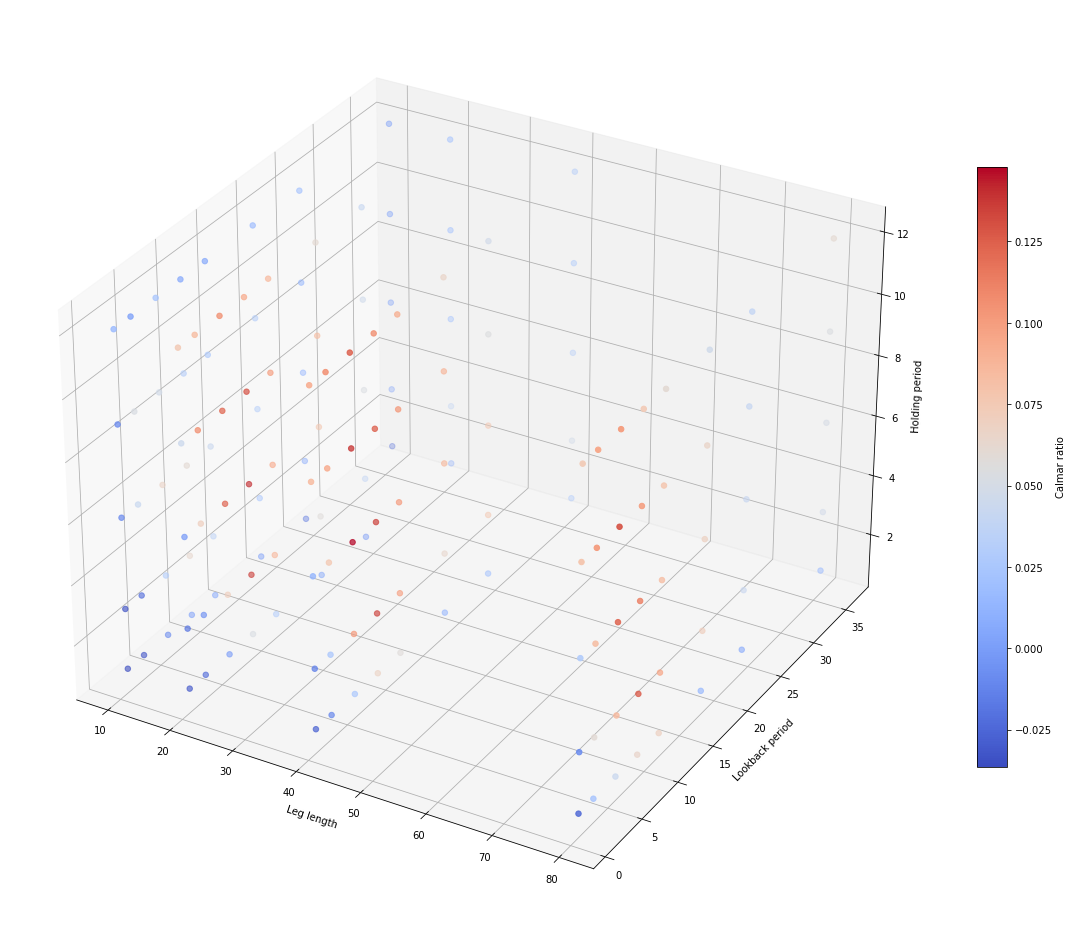

In [14]:
from mpl_toolkits.mplot3d import Axes3D
x_name, y_name, z_name = \
'Leg length' , 'Lookback period', 'Holding period'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_axe = strats_perf[x_name]
y_axe = strats_perf[y_name]
z_axe = strats_perf[z_name]
results = strats_perf['Calmar ratio']
img = ax.scatter(x_axe, y_axe, z_axe, c=results, cmap='coolwarm', s=30)
ax.set_xlabel(x_name)
ax.set_ylabel(y_name)
ax.set_zlabel(z_name)
cb = fig.colorbar(img, fraction=0.03)
cb.set_label('Calmar ratio')
fig.set_size_inches(15, 15)
fig.tight_layout()
plt.show()

# Analysis of a single strategy performance

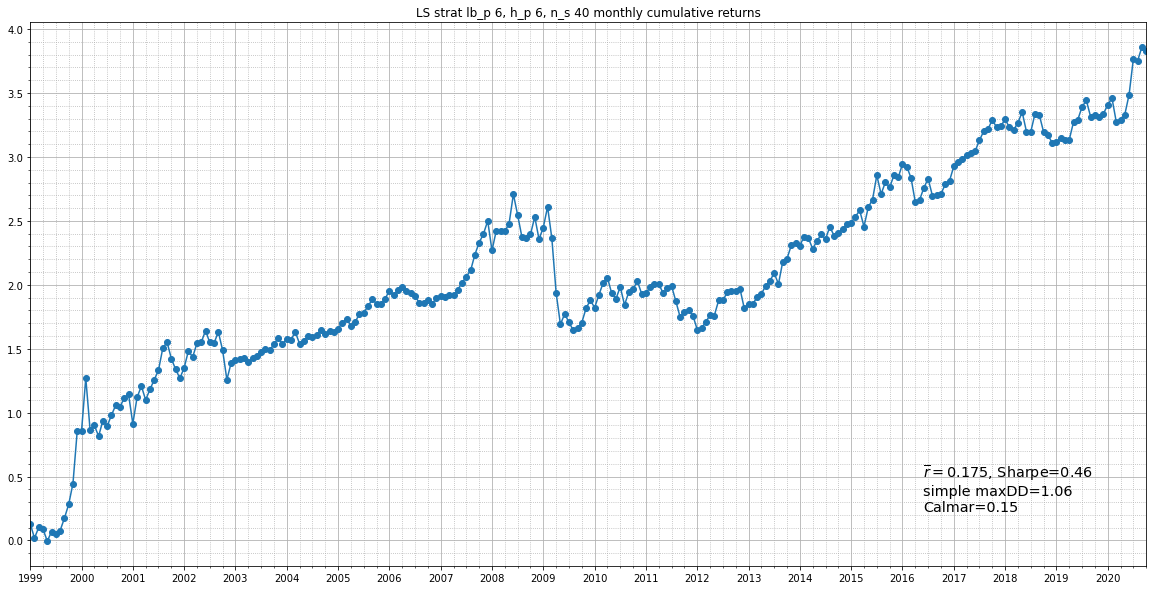

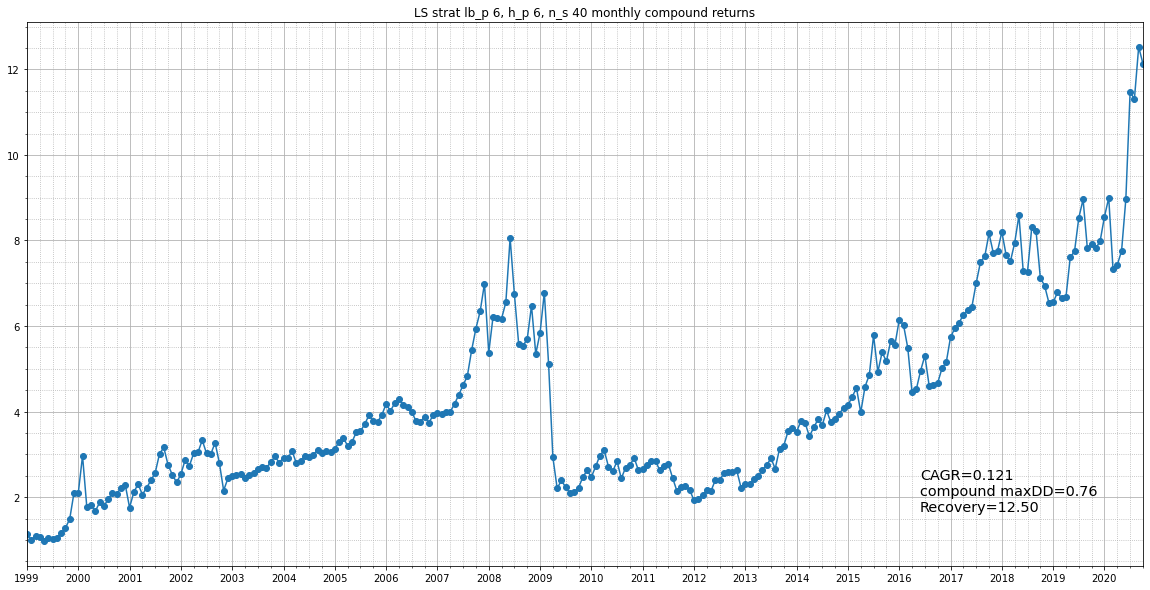

Lookback period: 6	Hold period: 6	Leg length: 40
simple mean: 0.1754019558387132	std_dev: 0.3394430134944826	sharp ratio: 0.46393102834465433
simple drawdown: 1.0640245988395292	calmar ratio: 0.1480023549142154
CAGR: 0.12110775191851109	compound drawdown: 0.760470033709733	recovery_ratio: 12.500970901241084
alpha: 0.08668804075226064	beta: -0.050545163305603893


In [19]:
import matplotlib.pyplot as plt
curr_strat = curr_store[2,2,2]
perfomance = curr_strat.adj_returns
#perfomance.plot(figsize=(20,10))
curr_strat.stats.graph_returns('cumulative')
curr_strat.stats.graph_returns('compound')
curr_strat.show_perf_results()

In [686]:
strats_perf.to_excel("Strategies no rebalance, no opt.xlsx")

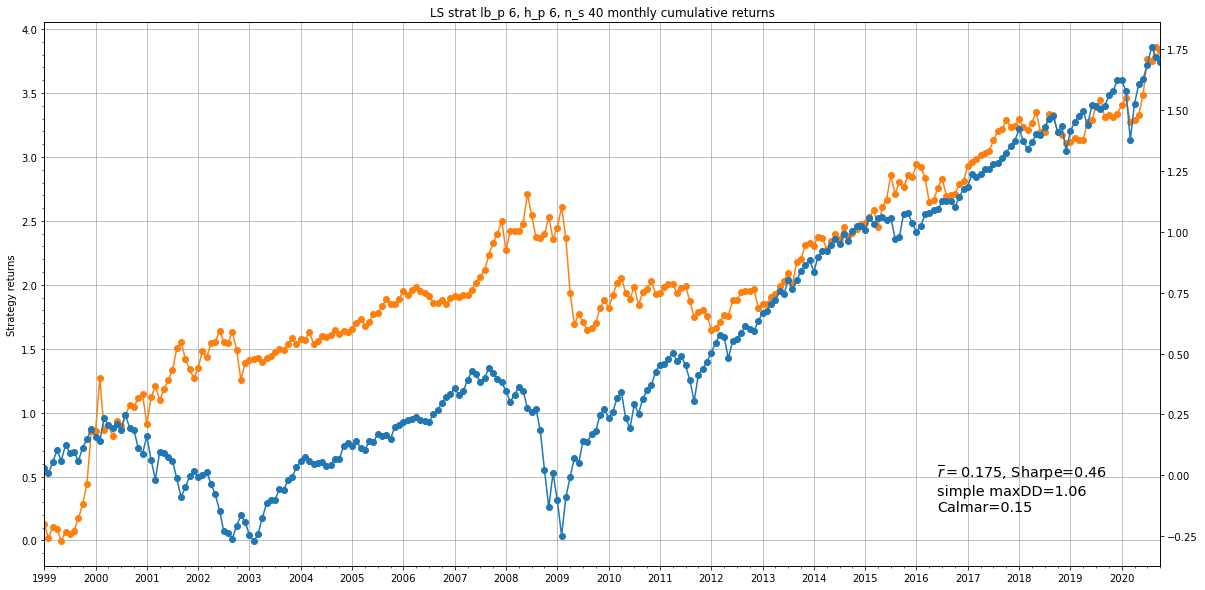

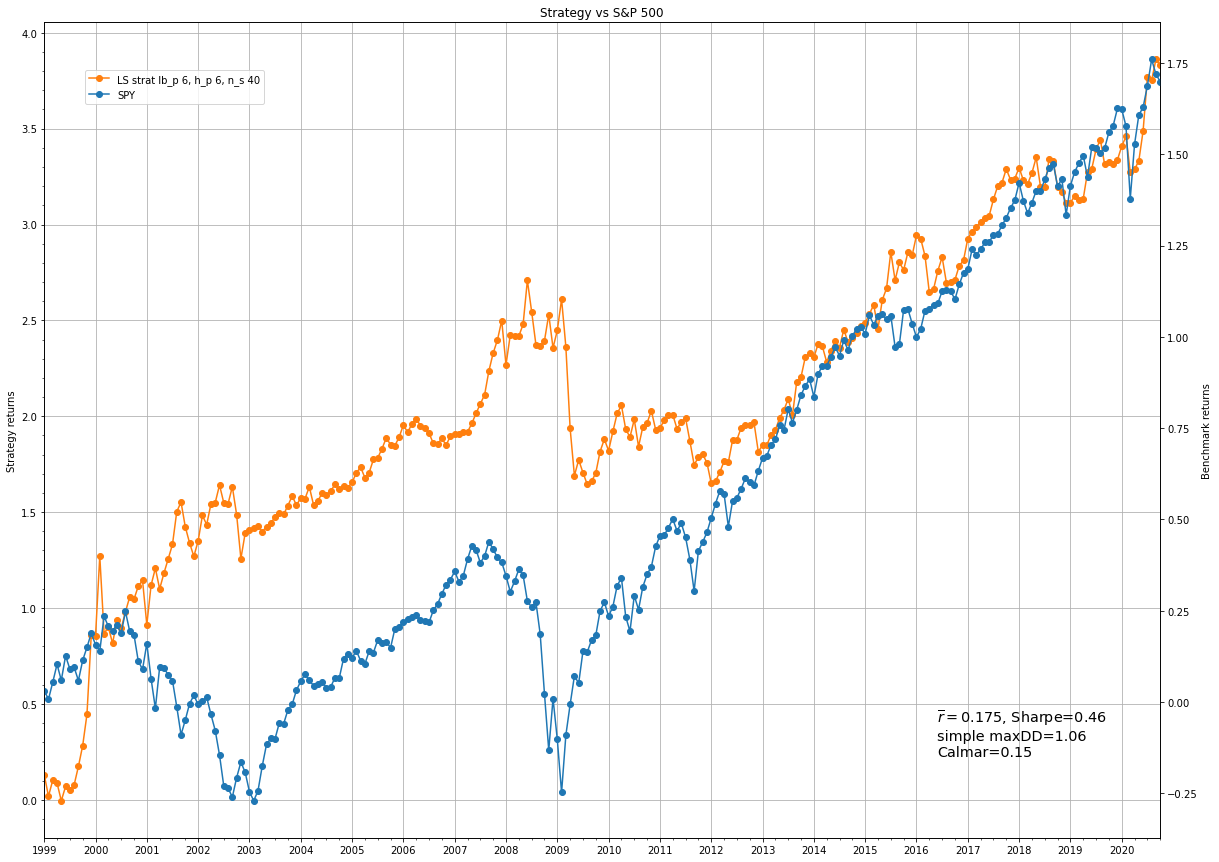

In [20]:
# Comparison with benchmark
fig = plt.gcf()
ax1 = benchmark.cum_returns.plot(style='o-', secondary_y=True, ylabel='Strategy returns')
curr_strat.stats.graph_returns('cumulative')
fig.legend(loc='lower left', bbox_to_anchor=(0.15, 0.8))
fig.axes[1].set_ylabel('Benchmark returns')
fig.axes[0].set_title('Strategy vs S&P 500')
fig.set_size_inches(20, 15)
fig
#fig.savefig(f"Benchmark vs LS strat lb_p {curr_strat.lookback_period}, \
#h_p {curr_strat.holding_period}, n_s {curr_strat.leg_length}.jpg")

In [21]:
# Correlations in comparison with SPY largest absolute returns
aligned_strats = pd.concat([curr_strat.stats.returns, spy_returns], axis=1).dropna()
largest_abs_rets = aligned_strats[aligned_strats['SPY'].abs()>=0.07]
from scipy.stats import pearsonr
pearsonr(largest_abs_rets.iloc[:,0], largest_abs_rets.iloc[:,1])


(-0.36437584557207864, 0.03139847858134501)

In [141]:
# Getting risk-free approximate monthly returns
bonds_part = risk_free[risk_free['Year']>=1999]
bonds_part['Year'] = pd.to_datetime(bonds_part['Year'], format='%Y')
bonds_part.index = bonds_part['Year'].dt.to_period('A')
bonds_part = bonds_part.loc[:,  '   RF'].resample('M').first().pad() /100 / 12
bonds_part = bonds_part.reindex(curr_strat.stats.returns.index).fillna(0)

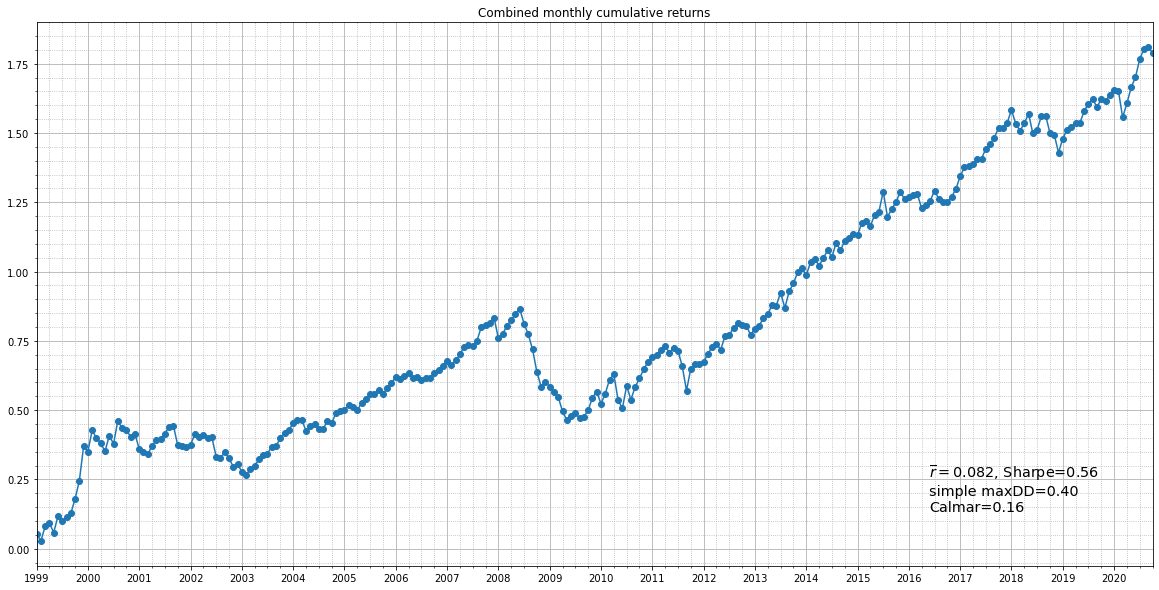

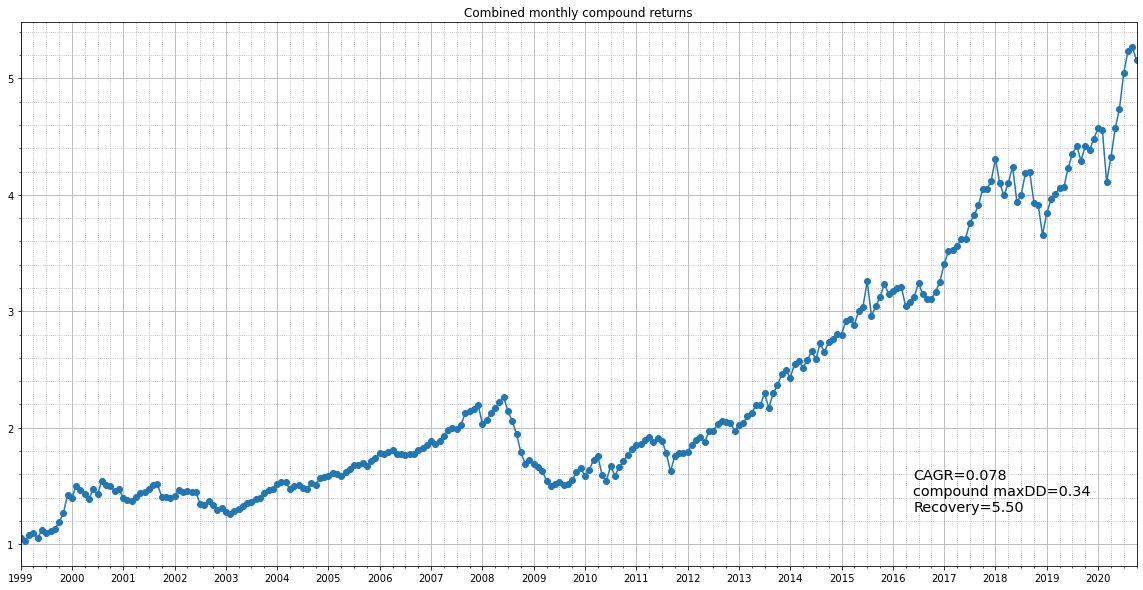

0.11445163158415295 0.4014845501679647 0.15941274436048372 1.7887081360764834 0.007054653293530253 0.8638044579357594


In [165]:
# Performance of combined Strategy
ls_and_spy_rets = 0.25 * curr_strat.stats.returns + 0.5 * benchmark.returns \
+ 0.25 * bonds_part
fig = plt.gcf()
ls_and_spy_rets.rename('Combined', inplace=True)
ls_and_spy = StrategyEvaluation(ls_and_spy_rets)
ls_and_spy.graph_returns('cumulative')
ls_and_spy.graph_returns('compound')
#fig.savefig(f"Combined portfolio compound.jpg", bbox_inches='tight')
print(ls_and_spy.std_dev, ls_and_spy.simple_drawdown, ls_and_spy.calmar_ratio, 
ls_and_spy.cum_returns[-1], ls_and_spy.alpha, ls_and_spy.beta)

In [ ]:
for x in curr_store.flat:
    fig = plt.gcf()
    x.stats.graph_returns('cumulative')
    fig.savefig(f"NonRebalanced NonOptimized/LS strat lb_p {x.lookback_period}, \
    h_p {x.holding_period}, n_s {x.leg_length}.jpg")
    plt.clf()

# Mean Reversion Strategy

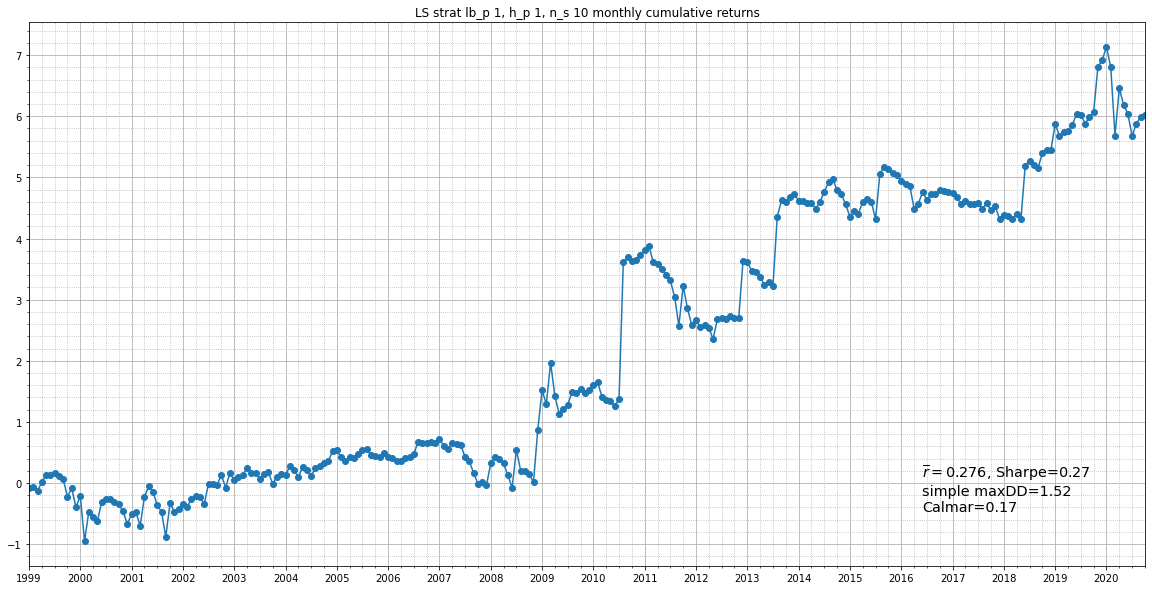

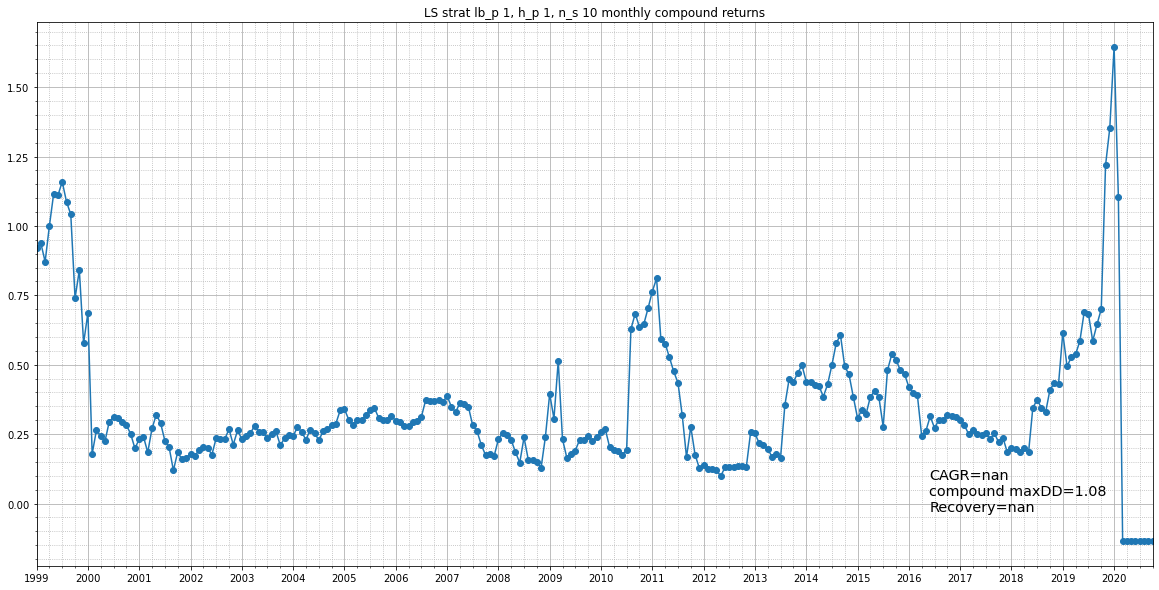

0.9437819164303046

In [138]:
mean_reversion = StrategyEvaluation(-curr_store[0,0,0].adj_returns)
mean_reversion.graph_returns("cumulative")
mean_reversion.graph_returns("compound")
mean_reversion.std_dev

In [156]:
print(mean_reversion.std_dev, mean_reversion.simple_drawdown, mean_reversion.calmar_ratio, 
mean_reversion.cum_returns[-1], mean_reversion.alpha, mean_reversion.beta)

0.9437819164303046 1.5232316285420198 0.16931859142241584 6.0224028115831345 0.06848533733286438 0.03384985474091518


In [158]:
# Correlations in comparison with SPY largest absolute returns
aligned_strats = pd.concat([mean_reversion.returns, spy_returns], axis=1).dropna()
largest_abs_rets = aligned_strats[aligned_strats['SPY'].abs()>=0.07]
from scipy.stats import pearsonr
pearsonr(largest_abs_rets.iloc[:,0], largest_abs_rets.iloc[:,1])

(0.5157913869944821, 0.0015173096915229469)

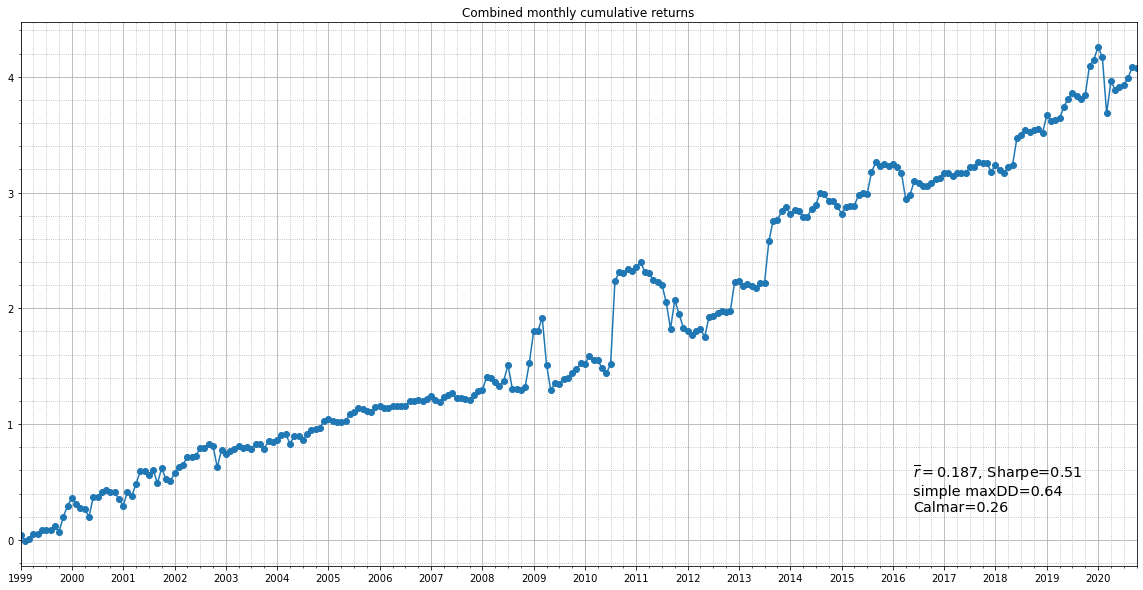

0.3292421871316222 0.642659525338962 0.26282261614725033 4.079105668626713 0.06466932900492516 0.07040112846273039


In [183]:
# Performance of combined Strategy
ls_and_spy_rets = 0.5 * curr_strat.stats.returns + 0.5*0.7 * mean_reversion.returns \
+ 0.5*0.3 * bonds_part
fig = plt.gcf()
ls_and_spy_rets.rename('Combined', inplace=True)
ls_and_spy = StrategyEvaluation(ls_and_spy_rets)
ls_and_spy.graph_returns('cumulative')
#fig.savefig(f"Combined portfolio compound.jpg", bbox_inches='tight')
print(ls_and_spy.std_dev, ls_and_spy.simple_drawdown, ls_and_spy.calmar_ratio, 
ls_and_spy.cum_returns[-1], ls_and_spy.alpha, ls_and_spy.beta)

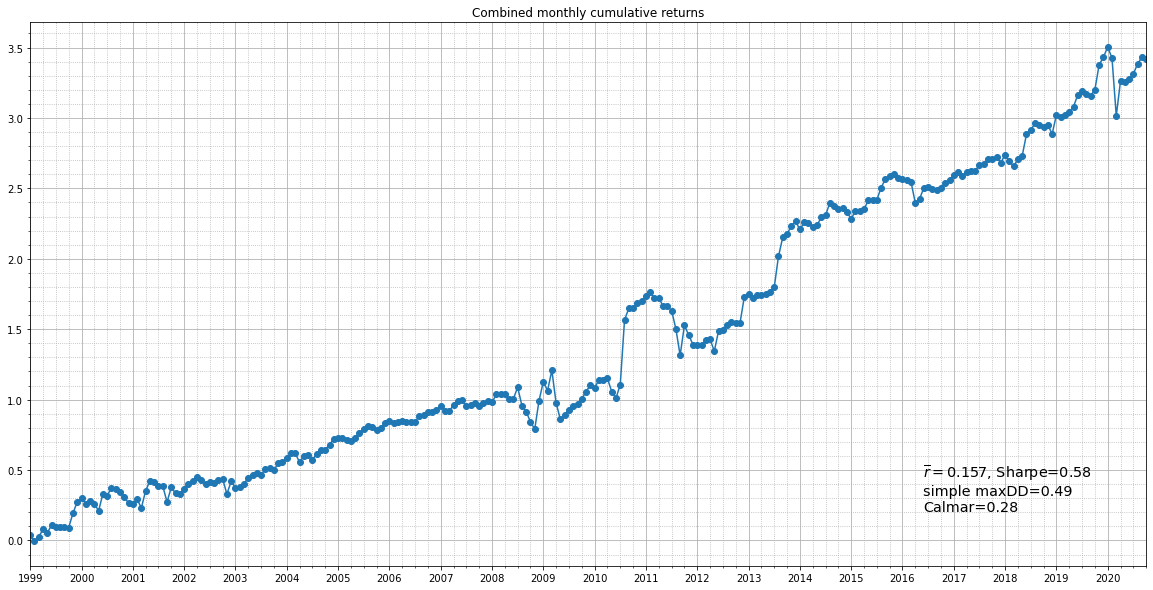

0.24041059720152388 0.4893296784893737 0.2833019892107359 3.4180493978967603 0.031509668705143025 0.2958294164377744


In [181]:
# Performance of combined Strategy
ls_and_spy_rets = 1/3 * curr_strat.stats.returns + 1/3 *0.7 * mean_reversion.returns \
+ 1/3*1.3 * benchmark.returns
fig = plt.gcf()
ls_and_spy_rets.rename('Combined', inplace=True)
ls_and_spy = StrategyEvaluation(ls_and_spy_rets)
ls_and_spy.graph_returns('cumulative')
#fig.savefig(f"Combined portfolio compound.jpg", bbox_inches='tight')
print(ls_and_spy.std_dev, ls_and_spy.simple_drawdown, ls_and_spy.calmar_ratio, 
ls_and_spy.cum_returns[-1], ls_and_spy.alpha, ls_and_spy.beta)

(2.6325856790292437, 19.306801383605027, -0.007184358688804848)

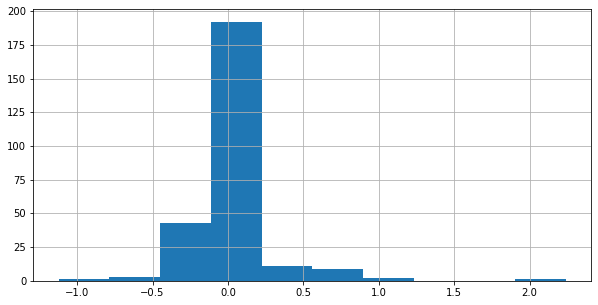

In [2091]:
mean_reversion.returns.hist(figsize=(10, 5))
mean_reversion.returns.skew(), mean_reversion.returns.kurtosis(), mean_reversion.returns.median()

# Analysis of a strategy constituents

In [1994]:
curr_strat.raw_returns[pd.to_datetime(curr_strat.raw_returns.index).year== 2020]

,0,1,2,3,4,5
2020-01-02 00:00:00,-0.0409766,0.149302,0.14404,0.121563,0.0232037,0.0256691
2020-02-03 00:00:00,0.111233,0.0455187,0.113186,0.0198392,-0.035674,0.0541445
2020-03-02 00:00:00,-0.0586508,-0.0706388,0.290172,-0.349768,-0.817098,-0.107587
2020-04-01 00:00:00,0.0492305,0.113081,-0.127974,-0.551145,0.505511,0.0952982
2020-05-01 00:00:00,0.0135924,0.217174,0.147395,-0.162693,-0.0137877,0.0625486
2020-06-01 00:00:00,0.0429434,0.256487,0.19581,0.16782,0.147942,0.125002
2020-07-01 00:00:00,0.190908,0.380046,0.229681,0.266563,0.342994,0.269763
2020-08-03 00:00:00,0.0295188,-0.0408541,-0.0126594,-0.109806,-0.0284993,0.0706279
2020-09-01 00:00:00,0.142114,0.0505221,0.0284699,0.203494,0.100634,0.124272
2020-10-01 00:00:00,-0.0375029,-0.0445136,-0.026859,-0.0615306,0.0113969,-0.0285686


In [1995]:
holdings = [x for x in curr_strat.holdings if np.datetime64('2020') == x[0].astype('datetime64[Y]')]
holdings

[(numpy.datetime64('2020-01-02T00:00:00.000000000'),
  array(['BBBY', 'STNE', 'DXCM', 'RNG', 'ICPT', 'SWKS', 'TECL', 'AUY',
         'LITEV', 'ACAD', 'AG', 'KLAC', 'BOLD', 'AMD', 'ENPH', 'ALNY',
         'LRCX', 'SEDG', 'SGEN', 'AXE', 'QRVO', 'VIPS', 'RAD', 'ARQL', 'RH',
         'WTW', 'SOXL', 'TSLA', 'PDD', 'ALLK', 'RETA', 'CLDR', 'MDCO',
         'ITCI', 'ARWR', 'TVIX', 'AUPH', 'AXSM', 'FTSV', 'KOD'],
        dtype=object),
  array(['ACB', 'JDST', 'SOXS', 'SAGE', 'WLL', 'UVXY', 'UGAZ', 'CHK', 'PCG',
         'DWT', 'CGC', 'BYND', 'DUST', 'IRBT', 'GUSH', 'ZS', 'GWPH', 'VXXB',
         'GRUB', 'WORK', 'ABMD', 'SQQQ', 'W', 'DXC', 'PLCE', 'BLUE', 'LB',
         'EQT', 'NSP', 'PINS', 'UBER', 'CLVS', 'TRIP', 'ETSY', 'LYFT',
         'DBX', 'SPXS', 'SERV', 'SPXU', 'CLF'], dtype=object)),
 (numpy.datetime64('2020-02-03T00:00:00.000000000'),
  array(['SIG', 'TDOC', 'RH', 'NVAX', 'RNG', 'QRVO', 'TDG', 'ARWR', 'PENN',
         'ICPT', 'NVDA', 'NTES', 'SEDG', 'ALNY', 'AAPL', 'LRCX', 'WTW',
    

In [2003]:
import yfinance
import concurrent.futures
import datetime
stocks = list()
curr_holdings = []
curr_holdings.extend([(x, 'Long') for x in holdings[2][1]])
curr_holdings.extend([(x, 'Short') for x in holdings[2][2]])
def get_company(info):
        ticker = yfinance.Ticker(info[0])
        #print(datetime.datetime.now().time(), info[0])
        try:
            name = ticker.info['longName']
        except:
            name = ''
        #stocks.append((info[0], name, info[1]))
        return info[0], name, info[1]

with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    stocks = executor.map(get_company, curr_holdings)
stocks_df = pd.DataFrame(stocks, columns=['Ticker', 'Name', 'Position']).reindex()



In [2004]:
pd.set_option('display.max_colwidth', None)
stocks_df

,Ticker,Name,Position
0,TECD,,Long
1,AMD,"Advanced Micro Devices, Inc.",Long
2,SOXL,Direxion Daily Semiconductor Bull 3X Shares,Long
3,DPZ,"Domino's Pizza, Inc.",Long
4,VIPS,Vipshop Holdings Limited,Long
5,SE,Sea Limited,Long
6,TECL,Direxion Daily Technology Bull 3X Shares,Long
7,NUAN,"Nuance Communications, Inc.",Long
8,EHTH,"eHealth, Inc.",Long
9,NIO,NIO Inc.,Long


<AxesSubplot:>

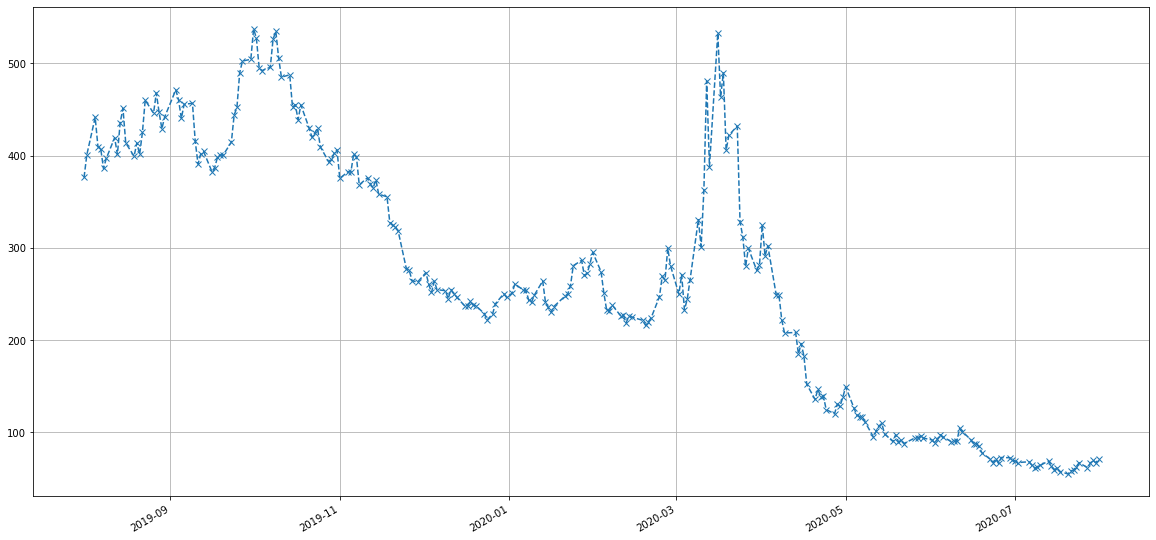

In [2009]:
all_quotes['LABD'].loc['2019-08':'2020-07'].plot(figsize=(20, 10), style='x--', grid=True)

# Data about S&P historical returns

In [22]:
table_spy = pd.read_html(
'http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/spearn.htm')
table_spy = table_spy[0]
# Getting right layout of rows and columns
table_spy.columns = table_spy.loc[0]
table_spy.drop(0, inplace=True)
table_spy.set_index('Year', inplace=True)
table_spy.index = table_spy.index.astype(int)


table_spy.drop(2020, inplace=True)
table_spy.loc[2020, 'S&P 500'] = 3638.35

# Reverse order from last year to first
table_spy = table_spy[::-1]
table_spy.index = table_spy.index.astype(int)

table_spy['Dividend Yield'] = \
table_spy['Dividend Yield'].str.rstrip('%').astype(float)/100
table_spy["Cum Dividend"] = (1+table_spy['Dividend Yield']).cumprod()

In [23]:
table_spy['S&P 500']=table_spy['S&P 500'].astype(float)
table_spy["Year Close"] = table_spy['S&P 500']/table_spy['Cum Dividend']
table_spy.loc[2020, 'Year Close'] = 3638.35
table_spy.head()

,Earnings Yield,Dividend Yield,S&P 500,Earnings,Dividends,Payout Ratio,Cum Dividend,Year Close
Year,,,,,,,,
2020,NaN,NaN,3638.35,NaN,NaN,NaN,NaN,3638.350000
2019,5.03%,0.0182,3230.78,162.35,58.80,36.22%,1.018200,3173.030839
2018,5.92%,0.0214,2506.85,148.34,53.61,36.14%,1.039989,2410.457075
2017,4.66%,0.0183,2673.61,124.51,48.93,39.30%,1.059021,2524.604587
2016,4.75%,0.0204,2238.83,106.26,45.70,43.01%,1.080625,2071.791170


In [24]:
spy_annual_close = table_spy['Year Close']
#print(spy_annual_close)
# first year is taken by first trading date of that year,
# last by last date
def av_ret_between_years(first, last):
    table = spy_annual_close.loc[last:first-1]
    cum_ret= table.iloc[0]/table.iloc[-1]-1
    av_ret= cum_ret/(last-first+1)
    print(av_ret)
av_ret_between_years(1999, 2020)
av_ret_between_years(1990, 1998)
av_ret_between_years(1965, 1989)
av_ret_between_years(1999, 2012)
av_ret_between_years(2013, 2020)

0.15550337604164657
0.38149021564185986
0.4069059592682793
0.03427444116363191
0.24844136622709279


In [25]:
# Returns of my strategy in most recent subperiod
rets_discussed = curr_store[2,2,3].stats.cum_returns
#rets_discussed = curr_store[3,1,1].stats.cum_returns
#rets_discussed = rets_discussed.loc[:'2011-12']
rets_discussed = rets_discussed.loc['2011-12':'2020-10']
print((rets_discussed[-1]-rets_discussed[0])/(len(rets_discussed)-1)*12)

0.1760012196486045


In [26]:
tbill_rates = risk_free.set_index('Year')['   RF']
tbill_rates.loc[1927:2011].mean()

3.6272941176470592

In [27]:
considered_strat = curr_store[3,1,1]
split_test1 = StrategyEvaluation(considered_strat.adj_returns.loc['1999':'2011'])
split_test2 = StrategyEvaluation(considered_strat.adj_returns.loc['2012':'2020'])
print(split_test1.sharp_ratio, split_test1.calmar_ratio)
print(split_test2.sharp_ratio, split_test2.calmar_ratio)

0.24675279109047793 0.09062434455235348
0.7043803601201435 0.473547109471806


## Example of pair trading

<AxesSubplot:>

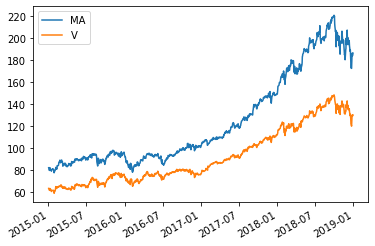

In [28]:
pivot_year = 2018
pair = all_quotes[['MA', 'V']]['2015':str(pivot_year)]
pair.plot()

[0.60098261] 17.775958884083153
(-3.0886981107453724, 0.09059540093643942, array([-3.90737061, -3.34221646, -3.04867279]))
(-3.087204417010659, 0.027514724986458575, {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7fa81d84b8e0>)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.531
Date:                Fri, 03 Sep 2021   Prob (F-statistic):            0.00208
Time:                        18:29:27   Log-Likelihood:                -919.55
No. Observations:                1005   AIC:                             1843.
Df Residuals:                    1003   BIC:                             1853.
Df Model:                           1           

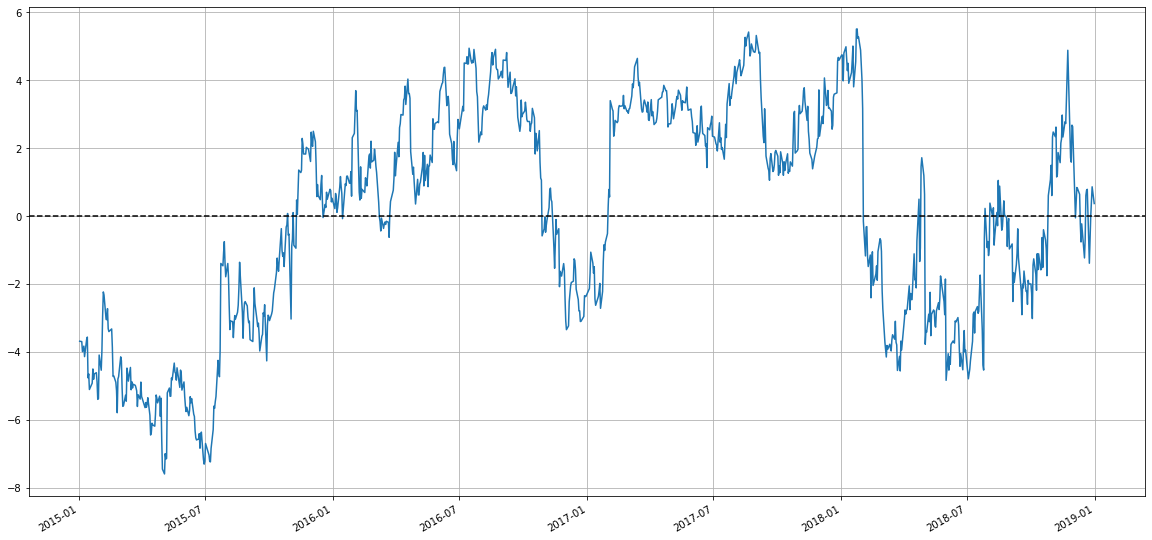

In [29]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, coint

model = LinearRegression().fit(X=pair['MA'].to_numpy().reshape(-1, 1), y=pair['V'])
print(model.coef_, model.intercept_)
spread = pair['V'] - model.predict(pair['MA'].to_numpy().reshape(-1, 1))
spread.plot(figsize=(20, 10), grid=True)
plt.axhline(y=0, c='black',  linestyle='dashed')
result = adfuller(spread, maxlag=0, regresults=True)
res_coint = coint(pair['V'], pair['MA'], maxlag=0)
print(res_coint)
print(result)
print(result[-1].resols.summary())

<AxesSubplot:xlabel='V', ylabel='MA'>

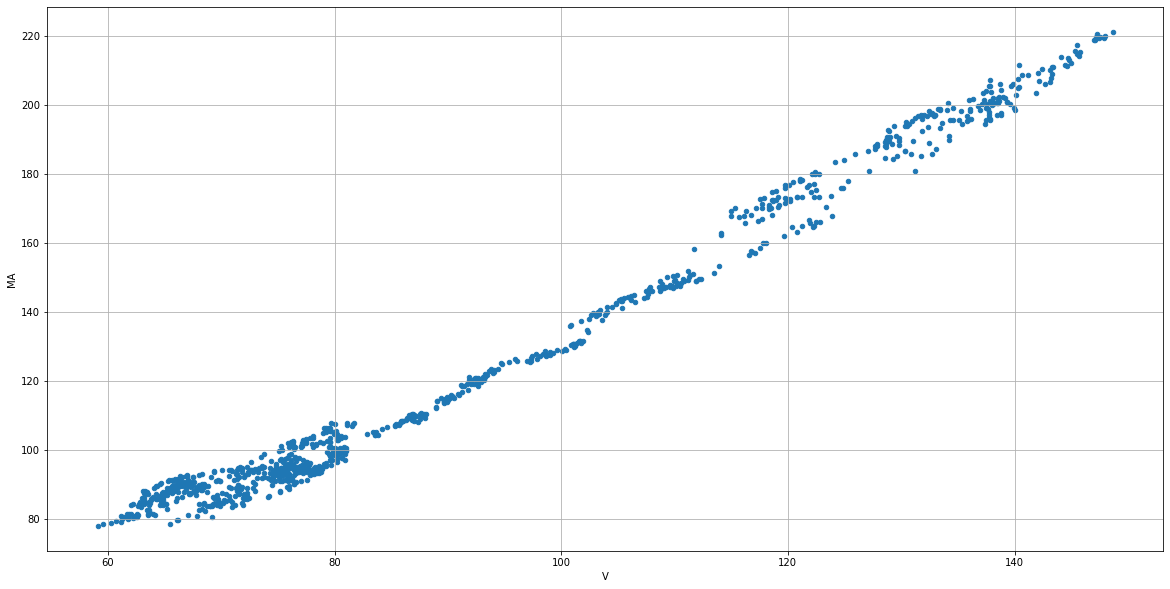

In [160]:
pair.plot(kind='scatter', x='V', y='MA', grid=True, figsize=(20, 10))

(-3.0886981107453724, 0.09059540093643942, array([-3.90737061, -3.34221646, -3.04867279]))
(-3.087204417010659, 0.027514724986458575, {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7f8612de09a0>)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.531
Date:                Sun, 23 May 2021   Prob (F-statistic):            0.00208
Time:                        18:36:26   Log-Likelihood:                -919.55
No. Observations:                1005   AIC:                             1843.
Df Residuals:                    1003   BIC:                             1853.
Df Model:                           1                                         
C

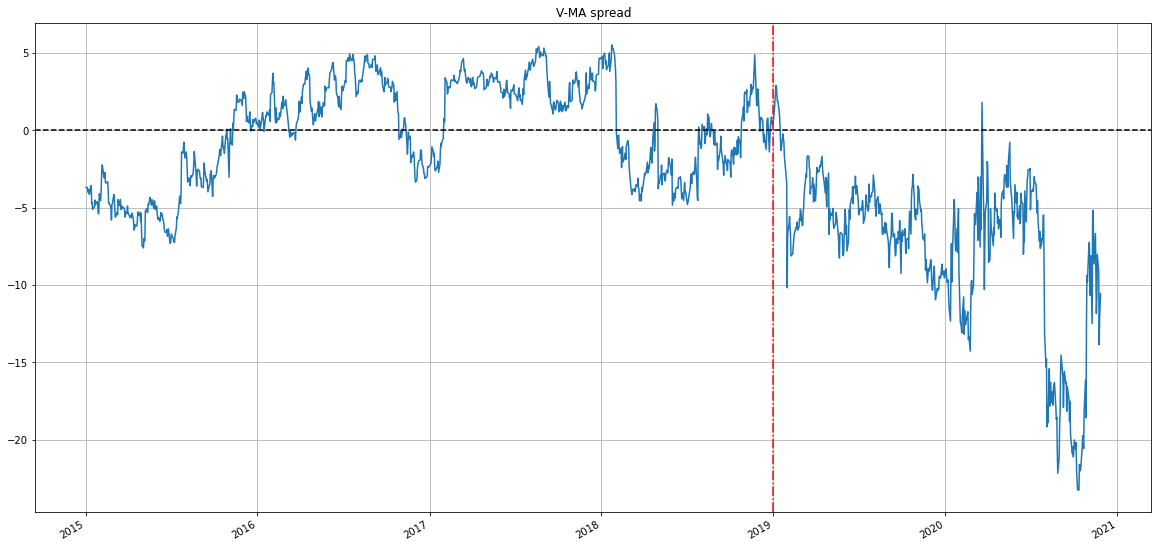

In [161]:
pair = all_quotes[['MA', 'V']]['2015':]
spread = pair['V'] - model.predict(pair['MA'].to_numpy().reshape(-1, 1))
spread.plot(figsize=(20, 10), grid=True)
plt.axhline(y=0, c='black',  linestyle='dashed')
plt.axvline(x=str(pivot_year+1), c='r', ls='-.')
plt.title('V-MA spread')
plt.savefig(f"Example spread V-MA.jpg")
print(res_coint)
print(result)
print(result[-1].resols.summary())

## Properties of 3 and 4th moments in distributions

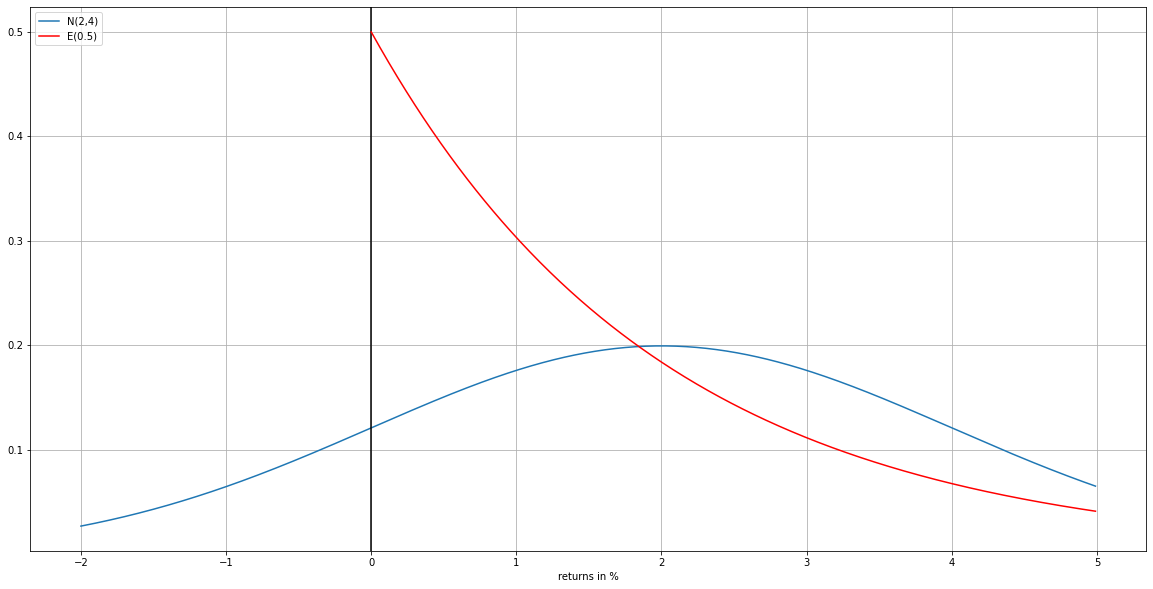

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon
x_range = np.arange(-2., 5., 0.01)
x_expon = np.arange(0., 5., 0.01)
fig, ax1 = plt.subplots()
ax1.plot(x_range, norm.pdf(x_range, 2, 2), label=r'N(2,4)')
ax1.set_xlabel('returns in %')
ax1.axvline(x=0, c='black')
ax1.grid()
#ax2 = ax1.twinx()
ax1.plot(x_expon, expon.pdf(x_expon, loc=0, scale=2), c='r', label='E(0.5)')
ax1.legend(loc=2)
#ax2.legend(loc=1)
plt.gcf().set_size_inches(20,10)

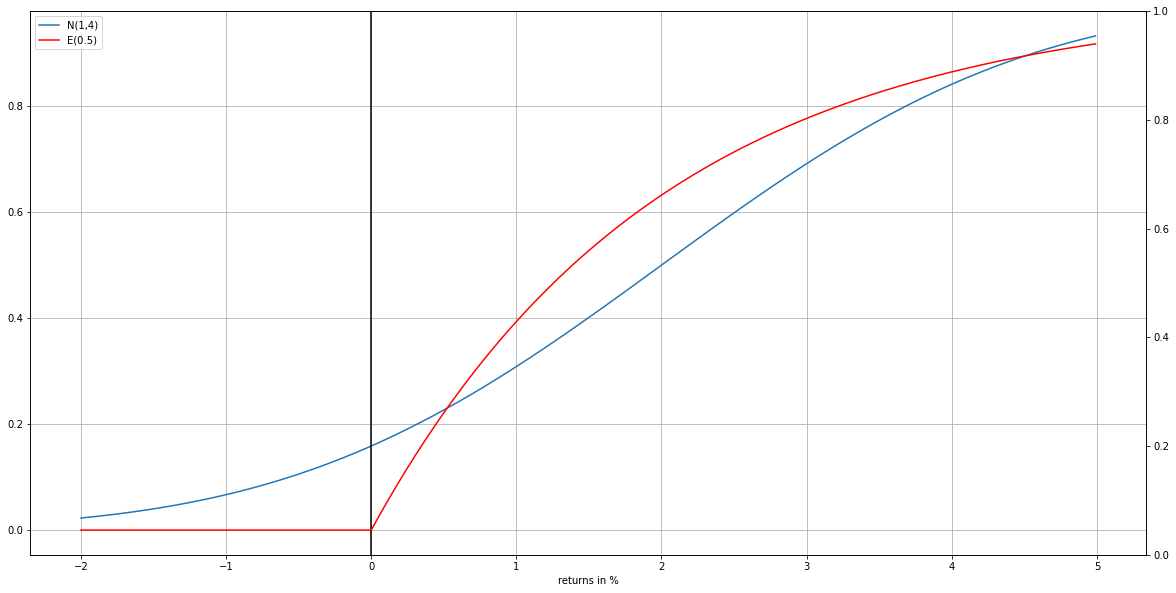

In [25]:
x_range = np.arange(-2., 5., 0.01)
x_expon = np.arange(1., 5., 0.01)
fig, ax1 = plt.subplots()
ax1.plot(x_range, norm.cdf(x_range, 2, 2), label=r'N(1,4)')
ax1.set_xlabel('returns in %')
ax1.axvline(x=0, c='black')
ax1.grid()
ax2 = ax1.twinx()
ax1.plot(x_range, expon.cdf(x_range, loc=0, scale=2), c='r', label='E(0.5)')
ax1.legend(loc=2)
#ax2.legend(loc=1)
plt.gcf().set_size_inches(20,10)

In [44]:
print(np.random.exponential(2, 10000).reshape(100, 100).mean(axis=0).std(),
      np.random.normal(2, 2, 10000).reshape(100, 100).mean(axis=0).std() )

0.20684089974202713 0.21346221962514308
